<a href="https://colab.research.google.com/github/ShraddhaSharma24/Machine-learning/blob/main/IoT_Device_Anomaly_Detection_in_Smart_Environments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from sklearn.preprocessing import StandardScaler
import shap

In [2]:
#Simulated IoT Sensor Data (5 sensors, 1000 timestamps)

np.random.seed(42)

n_timestamps = 1000
n_sensors = 5

In [3]:
data = np.random.normal(loc=0, scale=1, size=(n_timestamps, n_sensors))
anomaly_indices = np.random.choice(range(200, 800), size=10, replace=False)
for idx in anomaly_indices:
    data[idx] += np.random.normal(loc=5, scale=2, size=(n_sensors))  # Injecting anomalies

columns = ['Temperature', 'Humidity', 'Vibration', 'Current', 'Pressure']
df = pd.DataFrame(data, columns=columns)

In [4]:
# Label: 1 for normal, -1 for anomaly (for evaluation)
df['Label'] = 1
df.loc[anomaly_indices, 'Label'] = -1

In [5]:
# Preprocessing

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[columns])

In [6]:
# Isolation Forest for Anomaly Detection

iso_forest = IsolationForest(contamination=0.01, random_state=42)
df['Iso_Anomaly'] = iso_forest.fit_predict(scaled_data)

# Evaluation
print("Isolation Forest Detected Anomalies:", (df['Iso_Anomaly'] == -1).sum())

Isolation Forest Detected Anomalies: 10


In [7]:
 # LSTM Autoencoder for Anomaly Detection

X = scaled_data.reshape((scaled_data.shape[0], 1, scaled_data.shape[1]))

lstm_autoencoder = Sequential([
    LSTM(32, activation='relu', input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(16, activation='relu', return_sequences=False),
    RepeatVector(X.shape[1]),
    LSTM(16, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu', return_sequences=True),
    TimeDistributed(Dense(X.shape[2]))
])

lstm_autoencoder.compile(optimizer='adam', loss='mse')
history = lstm_autoencoder.fit(X, X, epochs=50, batch_size=32, verbose=0)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
# Reconstruction Error for Anomaly Detection
reconstructed = lstm_autoencoder.predict(X)
mse = np.mean(np.power(X - reconstructed, 2), axis=(1, 2))
threshold = np.percentile(mse, 95)  # Top 5% as anomaly threshold
df['LSTM_Anomaly'] = (mse > threshold).astype(int)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [9]:
# Combine Results

df['Final_Anomaly'] = ((df['Iso_Anomaly'] == -1) | (df['LSTM_Anomaly'] == 1)).astype(int)

print(df[['Label', 'Iso_Anomaly', 'LSTM_Anomaly', 'Final_Anomaly']].value_counts())


Label  Iso_Anomaly  LSTM_Anomaly  Final_Anomaly
 1      1           0             0                949
                    1             1                 41
-1     -1           1             1                  9
                    0             1                  1
Name: count, dtype: int64


In [10]:
#SHAP Explainability for Isolation Forest

explainer = shap.Explainer(iso_forest, scaled_data)
shap_values = explainer(scaled_data)

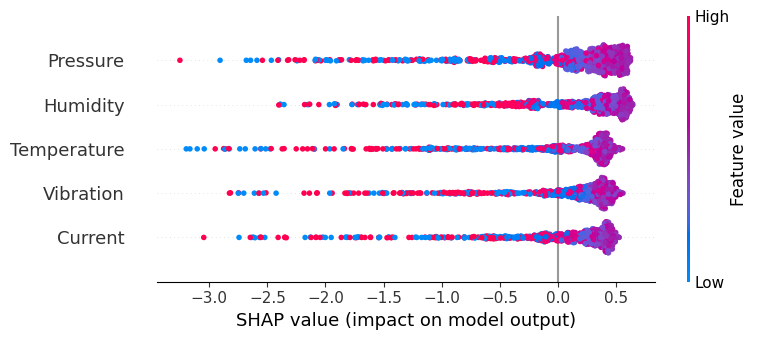

In [11]:
# Plot SHAP Summary
shap.summary_plot(shap_values, df[columns])


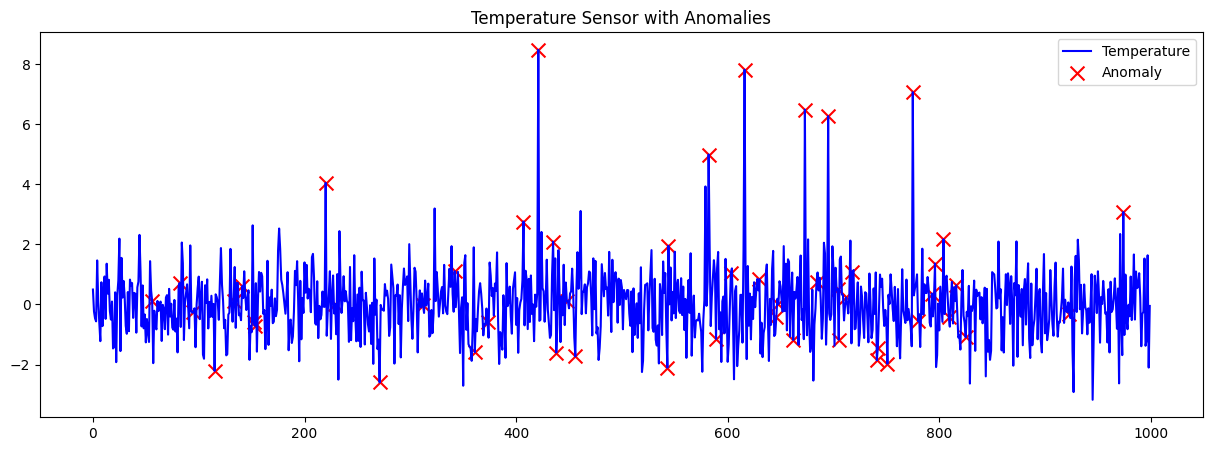

In [12]:
#Visualization

plt.figure(figsize=(15, 5))
plt.plot(df.index, df['Temperature'], label='Temperature', color='blue')
plt.scatter(df[df['Final_Anomaly'] == 1].index,
            df[df['Final_Anomaly'] == 1]['Temperature'],
            color='red', label='Anomaly', marker='x', s=100)
plt.legend()
plt.title("Temperature Sensor with Anomalies")
plt.show()